In [655]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv


## **Importing the libraries**

In [656]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## **Loading the dataset**

In [657]:
df_train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
df_test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [658]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## **Checking for the null values**

In [659]:
print(df_train.isnull().sum(axis = 0))
print(df_test.isnull().sum(axis = 0))

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


### Luckily we do not have to deal with null values

## **Lets first explore the output value (Count)**

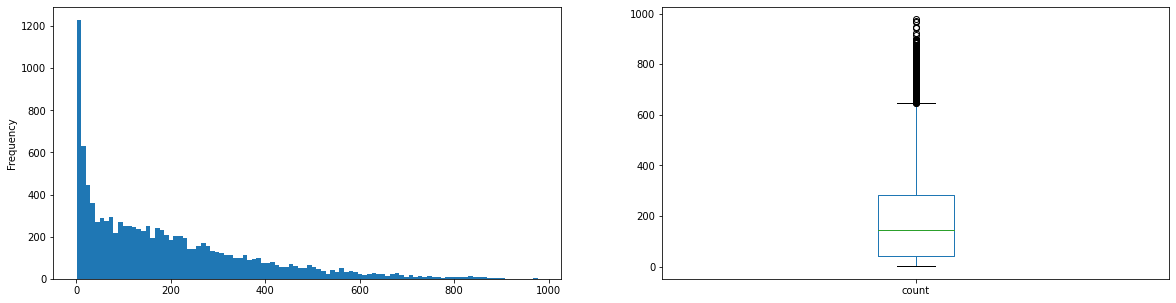

In [660]:
fig,ax = plt.subplots(1, 2)
fig.set_size_inches(20,5)
df_train['count'].plot(kind = 'hist', bins=100, ax =ax[0])
df_train['count'].plot(kind = 'box', ax =ax[1])

### As we can see that it contains the outliers. It happens when we have more rented bikes than ususal. So we need to remove the outliers as they can affect our models for predictions.

In [661]:
print('Before removing the outliers ', df_train.shape)
df_train = df_train[abs(df_train['count'] - df_train['count'].mean()) < 3*df_train['count'].std()]
print('After removing the outliers ', df_train.shape)
df_train.reset_index(drop = True, inplace = True)

Before removing the outliers  (10886, 12)
After removing the outliers  (10739, 12)


In [662]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Lets visualize the distribution of the output variable

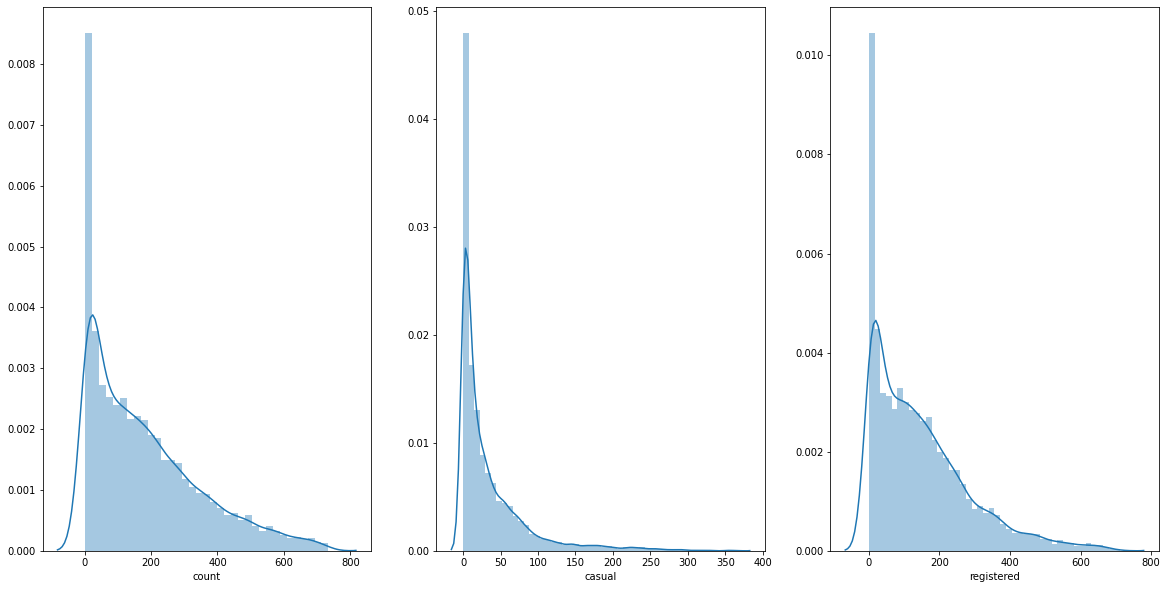

In [663]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 10)
sns.distplot(df_train["count"], ax = ax[0])
sns.distplot(df_train["casual"], ax = ax[1])
sns.distplot(df_train["registered"], ax = ax[2])

### As most of the machine learning models work best when the output variable is normally distributed, we will apply the log transformation to "Count" and "Registered" to make it more normally distributed

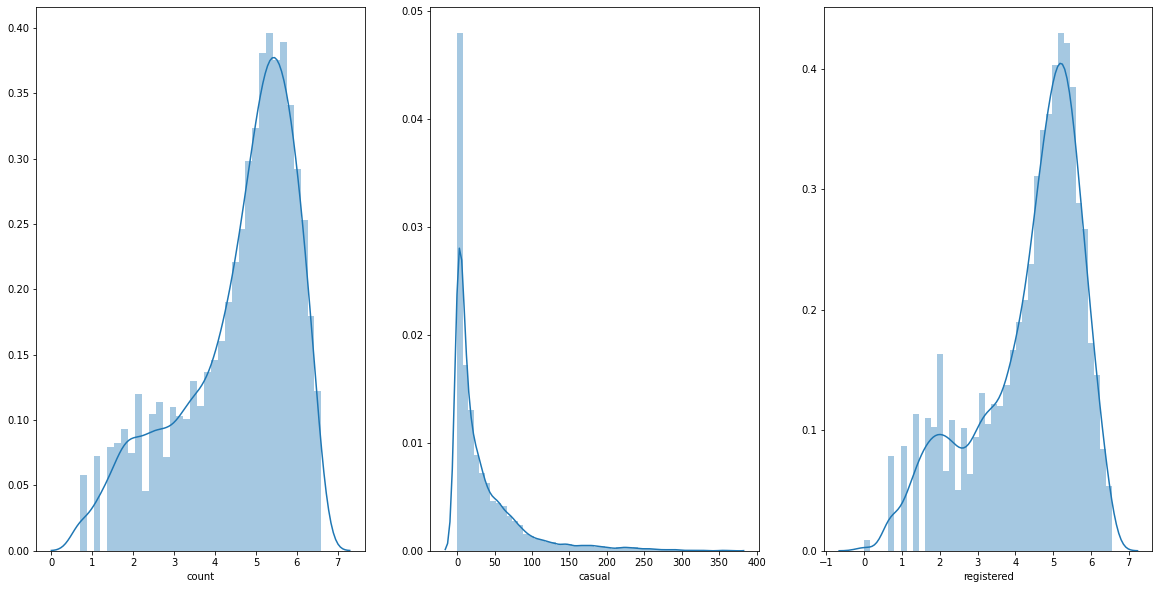

In [664]:
df_train['count'] = np.log(df_train['count'] + 1)
df_train['registered'] = np.log(df_train['registered'] + 1)
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 10)
sns.distplot(df_train["count"], ax = ax[0])
sns.distplot(df_train["casual"], ax = ax[1])
sns.distplot(df_train["registered"], ax = ax[2])


### Now the distribution is more normally distributed but remember we have added 1 before taking the log as np.log(0) will give infinity

### Extract the month, hour, year from the datetime column. I am not considering the day as the training set contains only dates from 1 to 19 and test data is of 20th day of each month.

In [665]:
def add_month(dataframe):
    month = pd.DatetimeIndex(dataframe['datetime']).month
    return month

def add_time(dataframe):
    time = pd.DatetimeIndex(dataframe['datetime']).hour
    return time

def add_year(dataframe):
    year = pd.DatetimeIndex(dataframe['datetime']).year
    return year

def add_day(dataframe):
    day = pd.DatetimeIndex(dataframe['datetime']).dayofweek
    return day

In [666]:
df_train['month'] = add_month(df_train)
df_train['time'] = add_time(df_train)
df_train['year'] = add_year(df_train)
df_train['day'] = add_day(df_train)
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,time,year,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,2.639057,2.833213,1,0,2011,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,3.496508,3.713572,1,1,2011,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,3.332205,3.496508,1,2,2011,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,2.397895,2.639057,1,3,2011,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,0.693147,0.693147,1,4,2011,5


### To find the dependence of independent variable on dependent variable we will calculate the correlation between them

In [667]:
corr = df_train.corr()
corr

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,time,year,day
season,1.000000,0.030368,-0.011228,0.008989,0.258933,0.265098,0.192185,-0.147608,0.094550,0.152520,0.155882,0.971783,-0.008423,-0.009936,-0.008587
holiday,0.030368,1.000000,-0.249896,-0.007732,0.002526,-0.003091,0.000478,0.008708,0.047270,-0.005383,0.002301,0.002544,0.001197,0.014461,-0.193879
workingday,-0.011228,-0.249896,1.000000,0.036463,0.021978,0.016831,-0.005637,0.012112,-0.332853,0.018391,-0.028963,-0.006159,-0.003258,-0.011337,-0.704789
weather,0.008989,-0.007732,0.036463,1.000000,-0.052114,-0.052922,0.405675,0.006146,-0.133326,-0.092871,-0.104727,0.012425,-0.020216,-0.009068,-0.048403
temp,0.258933,0.002526,0.021978,-0.052114,1.000000,0.985254,-0.056394,-0.019460,0.460774,0.318706,0.366059,0.257477,0.136961,0.049149,-0.032551
atemp,0.265098,-0.003091,0.016831,-0.052922,0.985254,1.000000,-0.035467,-0.059403,0.456319,0.314295,0.361897,0.264136,0.132128,0.046747,-0.034088
humidity,0.192185,0.000478,-0.005637,0.405675,-0.056394,-0.035467,1.000000,-0.320158,-0.341204,-0.311995,-0.327745,0.206028,-0.273058,-0.071137,-0.030547
windspeed,-0.147608,0.008708,0.012112,0.006146,-0.019460,-0.059403,-0.320158,1.000000,0.092334,0.121660,0.123224,-0.151127,0.145668,-0.016863,-0.023417
casual,0.094550,0.047270,-0.332853,-0.133326,0.460774,0.456319,-0.341204,0.092334,1.000000,0.502084,0.572267,0.090320,0.295037,0.132120,0.257293
registered,0.152520,-0.005383,0.018391,-0.092871,0.318706,0.314295,-0.311995,0.121660,0.502084,1.000000,0.992392,0.157556,0.570790,0.171999,0.005235


### We can draw the following obsevations from it:
#### 1. The correlation between temp and atemp is very high so we can discard any of the variable
#### 2. The correlation between count and time is highest and the correlation of count with year, month, temp,humidity is also significant

## Lets explore how the count is varying with different features

### 1. Time 

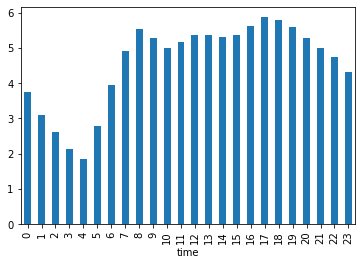

In [668]:
df_train.groupby('time')['count'].mean().plot(kind = 'bar')

### We can see that the maximum is around 7-9 am and 5-6 pm 

### 2. Month and Season

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


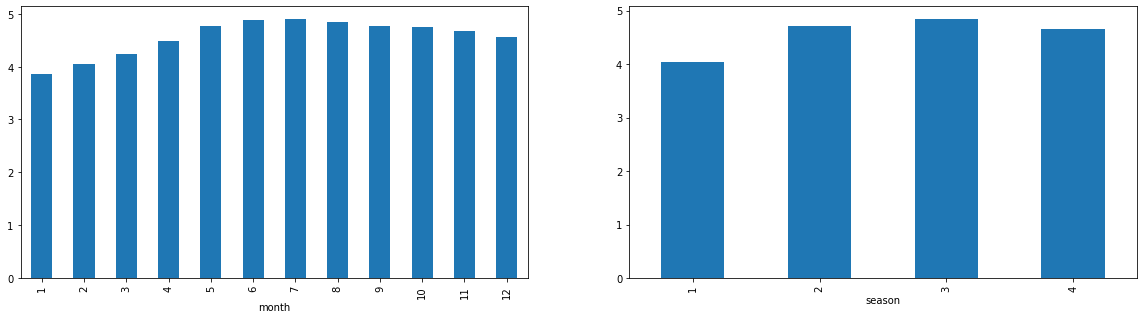

In [669]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,5)
df_train.groupby('month')['count'].mean().plot('bar', ax = ax[0])
df_train.groupby('season')['count'].mean().plot('bar', ax = ax[1])

### We can observe from the above graphs that the number of rented bikes are less in season 1 as compared to others

### 3. Temperature and Humidity

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


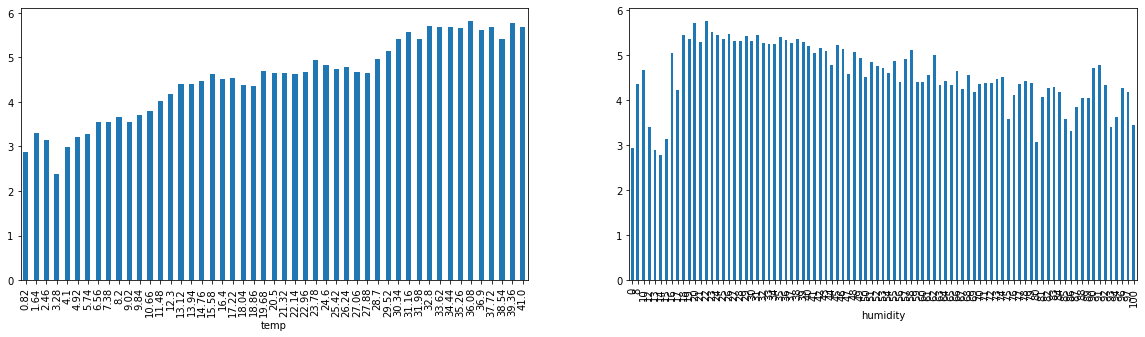

In [670]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,5)
df_train.groupby('temp')['count'].mean().plot('bar', ax = ax[0])
df_train.groupby('humidity')['count'].mean().plot('bar', ax = ax[1])

### We can see that there is a positive relation of temperature with count and a negative relation of humidity with the count, this verifies the correlation values that we got above 

### 4. Holiday amd Workingday

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


mean of count according to holidays  holiday
0    4.561865
1    4.581175
Name: count, dtype: float64
No of holiday = 1 and holdays = 0  holiday
0    10428
1      311
Name: count, dtype: int64


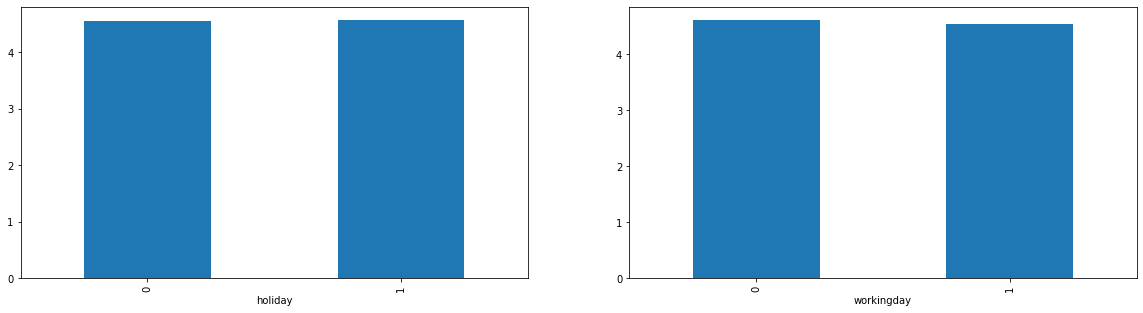

In [671]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,5)
df_train.groupby('holiday')['count'].mean().plot('bar', ax = ax[0])
df_train.groupby('workingday')['count'].mean().plot('bar', ax = ax[1])
print("mean of count according to holidays ", df_train.groupby('holiday')['count'].mean())
print("No of holiday = 1 and holdays = 0 ", df_train.groupby('holiday')['count'].count())


Three reasons to discard holiday and working day: 
1. Correlation value is low
2. Examples where holiday = 1 is less than 3 percent
3. The mean is almost similar
But we will make different models one with holiday and workingday and one without these features

### 5. Windspeed

In [672]:
df_train[df_train['windspeed'] == 0].shape

(1297, 16)

### As a lot of values are 0 in windspeed we can consider the following scenerios:
1.  It can actually be 0 at these points.
2.  It is too low to be measured, for example varying from 0 to 5.
3.  All zeros or part of them are nothing but NAs.


## So we will be estimating the missing values using the random forest

windspeed
0.0000     1297
6.0032      866
7.0015     1027
8.9981     1109
11.0014    1037
12.9980    1027
15.0013     942
16.9979     807
19.0012     664
19.9995     486
22.0028     366
23.9994     272
26.0027     231
27.9993     187
30.0026     109
31.0009      89
32.9975      79
35.0008      56
36.9974      22
39.0007      26
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: count, dtype: int64

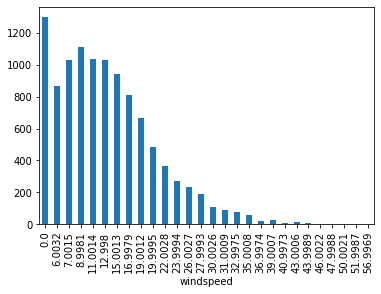

In [673]:
df_train.groupby('windspeed')['count'].count().plot(kind='bar')
df_train.groupby('windspeed')['count'].count()

In [674]:
df_train_windspeed_0 = df_train[df_train['windspeed'] == 0]
df_train_windspeed_not_0 = df_train[df_train['windspeed'] != 0]
print(df_train_windspeed_0.head())
print(df_train_windspeed_not_0.head())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered     count  month  time  year  day  
0        81        0.0       3    2.639057  2.833213      1     0  2011    5  
1        80        0.0       8    3.496508  3.713572      1     1  2011    5  
2        80        0.0       5    3.332205  3.496508      1     2  2011    5  
3        75        0.0       3    2.397895  2.639057      1     3  2011    5  
4        75        0.0       0    0.693147  0.693147      1     4  2011    5  
               datetime  season  holiday  workingday  wea

In [675]:
print(df_train_windspeed_0.shape)
print(df_train_windspeed_not_0.shape)

(1297, 16)
(9442, 16)


In [676]:
columns_for_windspeed = ['holiday', 'season', 'workingday', 'month', 'time', 'year', 'day', 'temp', 'humidity']

In [677]:
from sklearn.ensemble import RandomForestRegressor
rf_windspeed = RandomForestRegressor().fit(df_train_windspeed_not_0[columns_for_windspeed], df_train_windspeed_not_0['windspeed'])
df_train_windspeed_0['windspeed'] = rf_windspeed.predict(df_train_windspeed_0[columns_for_windspeed])

df_train = df_train_windspeed_0.append(df_train_windspeed_not_0, sort = 'datetime')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [678]:
print(df_train.shape)
df_train.head()

(10739, 16)


,atemp,casual,count,datetime,day,holiday,humidity,month,registered,season,temp,time,weather,windspeed,workingday,year
0,14.395,3,2.833213,2011-01-01 00:00:00,5,0,81,1,2.639057,1,9.84,0,1,9.381407,0,2011
1,13.635,8,3.713572,2011-01-01 01:00:00,5,0,80,1,3.496508,1,9.02,1,1,9.371290,0,2011
2,13.635,5,3.496508,2011-01-01 02:00:00,5,0,80,1,3.332205,1,9.02,2,1,9.551185,0,2011
3,14.395,3,2.639057,2011-01-01 03:00:00,5,0,75,1,2.397895,1,9.84,3,1,9.221880,0,2011
4,14.395,0,0.693147,2011-01-01 04:00:00,5,0,75,1,0.693147,1,9.84,4,1,8.121941,0,2011


In [679]:
print(df_train[df_train['windspeed'] == 0])
df_train.groupby('windspeed')['count'].count()

Empty DataFrame
Columns: [atemp, casual, count, datetime, day, holiday, humidity, month, registered, season, temp, time, weather, windspeed, workingday, year]
Index: []


windspeed
6.003200     866
6.242859       1
6.322656       1
6.462820       1
6.512936       1
            ... 
46.002200      3
47.998800      2
50.002100      1
51.998700      1
56.996900      2
Name: count, Length: 1313, dtype: int64

### As we can see now that the windspeed is not 0 for any example

### As we can not use the categorical values as input for models like linear regression we will convert it to one hot vector using pd.get_dummies

In [680]:
categorical_columns = ['holiday', 'season', 'workingday', 'weather', 'month', 'time', 'year', 'day']
for category in categorical_columns:
    df_train = df_train.join(pd.get_dummies(df_train[category], prefix = category))
    
df_train.head()

,atemp,casual,count,datetime,day,holiday,humidity,month,registered,season,...,time_23,year_2011,year_2012,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,14.395,3,2.833213,2011-01-01 00:00:00,5,0,81,1,2.639057,1,...,0,1,0,0,0,0,0,0,1,0
1,13.635,8,3.713572,2011-01-01 01:00:00,5,0,80,1,3.496508,1,...,0,1,0,0,0,0,0,0,1,0
2,13.635,5,3.496508,2011-01-01 02:00:00,5,0,80,1,3.332205,1,...,0,1,0,0,0,0,0,0,1,0
3,14.395,3,2.639057,2011-01-01 03:00:00,5,0,75,1,2.397895,1,...,0,1,0,0,0,0,0,0,1,0
4,14.395,0,0.693147,2011-01-01 04:00:00,5,0,75,1,0.693147,1,...,0,1,0,0,0,0,0,0,1,0


### Below function is equaivalent to pd.get_dummies

In [681]:
'''
def one_hot_encode(dataframe, column):
    for i in dataframe.groupby(column).count().index:
        s = column + "_" + str(i)
        a = []
        for element in dataframe[column]:
            if element == i:
                a.append(1)
            else:
                a.append(0)
        dataframe[s] = a
    return dataframe
'''

'\ndef one_hot_encode(dataframe, column):\n    for i in dataframe.groupby(column).count().index:\n        s = column + "_" + str(i)\n        a = []\n        for element in dataframe[column]:\n            if element == i:\n                a.append(1)\n            else:\n                a.append(0)\n        dataframe[s] = a\n    return dataframe\n'

In [682]:
df_train.columns

Index(['atemp', 'casual', 'count', 'datetime', 'day', 'holiday', 'humidity',
       'month', 'registered', 'season', 'temp', 'time', 'weather', 'windspeed',
       'workingday', 'year', 'holiday_0', 'holiday_1', 'season_1', 'season_2',
       'season_3', 'season_4', 'workingday_0', 'workingday_1', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'time_0', 'time_1', 'time_2',
       'time_3', 'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9',
       'time_10', 'time_11', 'time_12', 'time_13', 'time_14', 'time_15',
       'time_16', 'time_17', 'time_18', 'time_19', 'time_20', 'time_21',
       'time_22', 'time_23', 'year_2011', 'year_2012', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6'],
      dtype='object')

### Some algorithms performed better when the input data is normalized so we will normalize temp, humidity and windspeed

In [683]:
def normalize(dataframe, columns):
    for column in columns:
        dataframe[column]=((dataframe[column]-dataframe[column].min())/(dataframe[column].max()-dataframe[column].min()))
    return dataframe

In [684]:
df_train = normalize(df_train, columns=['temp', 'humidity', 'windspeed'])
df_train.head()

,atemp,casual,count,datetime,day,holiday,humidity,month,registered,season,...,time_23,year_2011,year_2012,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,14.395,3,2.833213,2011-01-01 00:00:00,5,0,0.81,1,2.639057,1,...,0,1,0,0,0,0,0,0,1,0
1,13.635,8,3.713572,2011-01-01 01:00:00,5,0,0.80,1,3.496508,1,...,0,1,0,0,0,0,0,0,1,0
2,13.635,5,3.496508,2011-01-01 02:00:00,5,0,0.80,1,3.332205,1,...,0,1,0,0,0,0,0,0,1,0
3,14.395,3,2.639057,2011-01-01 03:00:00,5,0,0.75,1,2.397895,1,...,0,1,0,0,0,0,0,0,1,0
4,14.395,0,0.693147,2011-01-01 04:00:00,5,0,0.75,1,0.693147,1,...,0,1,0,0,0,0,0,0,1,0


### As we have taken all the information from the datetime column we can remove that

In [685]:
def remove_columns(dataframe, columns):
    dataframe = dataframe.drop(columns, axis = 1)
    return dataframe

In [686]:
df_train = remove_columns(df_train, ['datetime', 'atemp']) 
print(df_train.columns)
df_train.head()

Index(['casual', 'count', 'day', 'holiday', 'humidity', 'month', 'registered',
       'season', 'temp', 'time', 'weather', 'windspeed', 'workingday', 'year',
       'holiday_0', 'holiday_1', 'season_1', 'season_2', 'season_3',
       'season_4', 'workingday_0', 'workingday_1', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'time_0', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19', 'time_20', 'time_21', 'time_22',
       'time_23', 'year_2011', 'year_2012', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6'],
      dtype='object')


,casual,count,day,holiday,humidity,month,registered,season,temp,time,...,time_23,year_2011,year_2012,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,3,2.833213,5,0,0.81,1,2.639057,1,0.224490,0,...,0,1,0,0,0,0,0,0,1,0
1,8,3.713572,5,0,0.80,1,3.496508,1,0.204082,1,...,0,1,0,0,0,0,0,0,1,0
2,5,3.496508,5,0,0.80,1,3.332205,1,0.204082,2,...,0,1,0,0,0,0,0,0,1,0
3,3,2.639057,5,0,0.75,1,2.397895,1,0.224490,3,...,0,1,0,0,0,0,0,0,1,0
4,0,0.693147,5,0,0.75,1,0.693147,1,0.224490,4,...,0,1,0,0,0,0,0,0,1,0


### Split the dataset into input and output

In [687]:
df_train_y = df_train[['count', 'casual', 'registered']]
df_train_x = remove_columns(df_train, ['casual', 'registered', 'count'])

### Split the dataset into training and testing

In [688]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

### We will make 2 models in the first one we directly estimate the variable "Count" and in the 2nd one we will estimate "Casual" and "Registered" and "Count" will be equal to their summition

In [689]:
y_train_casual = y_train['casual']
y_train_registered = y_train['registered']
y_train_total = y_train['count']
y_test_casual = y_test['casual']
y_test_registered = y_test['registered']
y_test_total = y_test['count']

### Importing the Machine Learning Libraries

In [690]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

### Using Linear Regression

In [691]:
all_predictions = []

#as we have the one hot vector we will remove this categorical data
categorical_data = ['holiday', 'season', 'workingday', 'month', 'time', 'year', 'day']
lr_train_x = remove_columns(x_train, categorical_data)
lr_test_x = remove_columns(x_test, categorical_data)

lr = LinearRegression().fit(lr_train_x, y_train_total)
lr_predictions_on_test_data = np.exp(lr.predict(lr_test_x)) - 1

lr_predictions_on_train_data = np.exp(lr.predict(lr_train_x))

all_predictions.append(lr_predictions_on_train_data)
all_predictions.append(lr_predictions_on_test_data)

for i, prediction in enumerate(all_predictions):
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    if i == 0:
        print(np.sqrt(mean_squared_log_error( np.exp(y_train_total)-1, pre )))
    else:
        print(np.sqrt(mean_squared_log_error( np.exp(y_test_total)-1, pre )))

0.5846730141754327
0.5701443943390606


### For the Random Forest we do not need the one hot encoding for the categorical variables

In [692]:
all_predictions = []

training_columns = ['holiday', 'season', 'workingday', 'month', 'time', 'year', 'day', 'temp', 'humidity', 'windspeed']
train_x = x_train[training_columns]
test_x = x_test[training_columns]

rf = RandomForestRegressor(n_estimators=100, max_depth = 10, min_samples_split=5).fit(train_x, y_train_total)
predictions_on_test_data = np.exp(rf.predict(test_x)) - 1

predictions_on_train_data = np.exp(rf.predict(train_x))

all_predictions.append(predictions_on_train_data)
all_predictions.append(predictions_on_test_data)

for i, prediction in enumerate(all_predictions):
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    if i == 0:
        print(np.sqrt(mean_squared_log_error( np.exp(y_train_total)-1, pre )))
    else:
        print(np.sqrt(mean_squared_log_error( np.exp(y_test_total)-1, pre )))

0.2765126690276842
0.3395590029202937


### Random Forest with different model for "Casual" and "Registered"

In [693]:
all_predictions = []

training_columns = ['holiday', 'season', 'workingday', 'month', 'time', 'year', 'day', 'temp', 'humidity', 'windspeed']
train_x = x_train[training_columns]
test_x = x_test[training_columns]

rf_casual = RandomForestRegressor(n_estimators=300, max_depth = 10, min_samples_split=8).fit(train_x, y_train_casual)
predictions_casual = rf_casual.predict(test_x)


rf_registered = RandomForestRegressor().fit(train_x, y_train_registered)
predictions_registered = np.exp(rf_registered.predict(test_x))-1

predictions = predictions_casual + predictions_registered

predictions_casual_train = rf_casual.predict(train_x)
predictions_registered_train = np.exp(rf_registered.predict(train_x))-1

predictions_train = predictions_casual_train + predictions_registered_train

all_predictions.append(predictions_train)
all_predictions.append(predictions)

for i, prediction in enumerate(all_predictions):
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    if i == 0:
        print(np.sqrt(mean_squared_log_error( np.exp(y_train_total)-1, pre )))
    else:
        print(np.sqrt(mean_squared_log_error( np.exp(y_test_total)-1, pre )))

0.16140823487578787
0.2983285686252402


## Processing of the test data
### 1. Addition of the day, month, time, year
### 2. Removing the zero in the windspeed
### 3. Sorting the data according to datetime
### 4. Adding the one hot vector in case you want to predict the count using Linear Regression
### 5. Normalisation
### 6. Prediction
### 7. Storing

In [695]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [696]:
df_test['month'] = add_month(df_test)
df_test['time'] = add_time(df_test)
df_test['year'] = add_year(df_test)
df_test['day'] = add_day(df_test)
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,time,year,day
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,2011,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,1,2011,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,2,2011,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,3,2011,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,4,2011,3


In [697]:
df_test_windspeed_0 = df_test[df_test['windspeed'] == 0]
df_test_windspeed_not_0 = df_test[df_test['windspeed'] != 0]
columns_for_windspeed = ['holiday', 'season', 'workingday', 'month', 'time', 'year', 'day', 'temp', 'humidity']

df_test_windspeed_0['windspeed'] = rf_windspeed.predict(df_test_windspeed_0[columns_for_windspeed])

df_test = df_test_windspeed_0.append(df_test_windspeed_not_0, sort = 'datetime')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [698]:
df_test.head()

,atemp,datetime,day,holiday,humidity,month,season,temp,time,weather,windspeed,workingday,year
1,13.635,2011-01-20 01:00:00,3,0,56,1,1,10.66,1,1,12.320630,1,2011
2,13.635,2011-01-20 02:00:00,3,0,56,1,1,10.66,2,1,12.750368,1,2011
12,16.665,2011-01-20 12:00:00,3,0,42,1,1,12.30,12,2,21.911077,1,2011
60,8.335,2011-01-22 13:00:00,5,0,35,1,1,3.28,13,1,30.399642,0,2011
62,7.575,2011-01-22 15:00:00,5,0,28,1,1,4.92,15,1,28.619854,0,2011


In [699]:
df_test = df_test.sort_values(by='datetime')
df_test.head()

,atemp,datetime,day,holiday,humidity,month,season,temp,time,weather,windspeed,workingday,year
0,11.365,2011-01-20 00:00:00,3,0,56,1,1,10.66,0,1,26.002700,1,2011
1,13.635,2011-01-20 01:00:00,3,0,56,1,1,10.66,1,1,12.320630,1,2011
2,13.635,2011-01-20 02:00:00,3,0,56,1,1,10.66,2,1,12.750368,1,2011
3,12.880,2011-01-20 03:00:00,3,0,56,1,1,10.66,3,1,11.001400,1,2011
4,12.880,2011-01-20 04:00:00,3,0,56,1,1,10.66,4,1,11.001400,1,2011


In [700]:
categorical_columns = ['holiday', 'season', 'workingday', 'weather', 'month', 'time', 'year', 'day']
for category in categorical_columns:
    df_test = df_test.join(pd.get_dummies(df_test[category], prefix = category))
    
print(df_test.head())
print(df_test.columns)

    atemp             datetime  day  holiday  humidity  month  season   temp  \
0  11.365  2011-01-20 00:00:00    3        0        56      1       1  10.66   
1  13.635  2011-01-20 01:00:00    3        0        56      1       1  10.66   
2  13.635  2011-01-20 02:00:00    3        0        56      1       1  10.66   
3  12.880  2011-01-20 03:00:00    3        0        56      1       1  10.66   
4  12.880  2011-01-20 04:00:00    3        0        56      1       1  10.66   

   time  weather  ...  time_23  year_2011  year_2012  day_0  day_1  day_2  \
0     0        1  ...        0          1          0      0      0      0   
1     1        1  ...        0          1          0      0      0      0   
2     2        1  ...        0          1          0      0      0      0   
3     3        1  ...        0          1          0      0      0      0   
4     4        1  ...        0          1          0      0      0      0   

   day_3  day_4  day_5  day_6  
0      1      0      0  

In [701]:
df_test = normalize(df_test, columns=['temp', 'humidity', 'windspeed'])
df_test.head()

,atemp,datetime,day,holiday,humidity,month,season,temp,time,weather,...,time_23,year_2011,year_2012,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,11.365,2011-01-20 00:00:00,3,0,0.47619,1,1,0.25,0,1,...,0,1,0,0,0,0,1,0,0,0
1,13.635,2011-01-20 01:00:00,3,0,0.47619,1,1,0.25,1,1,...,0,1,0,0,0,0,1,0,0,0
2,13.635,2011-01-20 02:00:00,3,0,0.47619,1,1,0.25,2,1,...,0,1,0,0,0,0,1,0,0,0
3,12.880,2011-01-20 03:00:00,3,0,0.47619,1,1,0.25,3,1,...,0,1,0,0,0,0,1,0,0,0
4,12.880,2011-01-20 04:00:00,3,0,0.47619,1,1,0.25,4,1,...,0,1,0,0,0,0,1,0,0,0


In [702]:
df_datetime = df_test['datetime']
df_test = remove_columns(df_test, ['datetime', 'atemp']) 
print(df_test.columns)

Index(['day', 'holiday', 'humidity', 'month', 'season', 'temp', 'time',
       'weather', 'windspeed', 'workingday', 'year', 'holiday_0', 'holiday_1',
       'season_1', 'season_2', 'season_3', 'season_4', 'workingday_0',
       'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5', 'time_6',
       'time_7', 'time_8', 'time_9', 'time_10', 'time_11', 'time_12',
       'time_13', 'time_14', 'time_15', 'time_16', 'time_17', 'time_18',
       'time_19', 'time_20', 'time_21', 'time_22', 'time_23', 'year_2011',
       'year_2012', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6'],
      dtype='object')


In [703]:
df_test.columns.shape == df_train_x.columns.shape

True

In [704]:
training_columns = ['holiday', 'season', 'workingday', 'month', 'time', 'year', 'day', 'temp', 'humidity', 'windspeed']
df_test_final = df_test[training_columns]
predictions = np.exp(rf.predict(df_test_final))-1

### If you want to predict using 2 models

In [709]:
'''
predictions_casual = rf_casual.predict(df_test_final)

predictions_registered = np.exp(rf_registered.predict(df_test_final))-1

predictions = predictions_casual + predictions_registered

print(predictions[:5])
'''


'\npredictions_casual = rf_casual.predict(df_test_final)\n\npredictions_registered = np.exp(rf_registered.predict(df_test_final))-1\n\npredictions = predictions_casual + predictions_registered\n\nprint(predictions[:5])\n'

In [707]:
data = {'datetime': df_datetime, 'count': predictions}
df = pd.DataFrame(data)
df.head()

,datetime,count
0,2011-01-20 00:00:00,10.455102
1,2011-01-20 01:00:00,4.383021
2,2011-01-20 02:00:00,2.921741
3,2011-01-20 03:00:00,2.136235
4,2011-01-20 04:00:00,2.059065


In [708]:
df.to_csv('submission.csv', index = False)

## ** While training for submitting use the entire dataset to train **